In [82]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
# We will use 'smf' for the mixed-effects model formula
import statsmodels.formula.api as smf 
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import scipy.stats as stats
import itertools

from statannotations.Annotator import Annotator

preprocessing

In [83]:
data_df = pd.read_excel('../data/qqs_plant_roots_data.xlsx', header=1)

df = data_df.copy()

if 'Name' in df.columns:
    df['Name'] = df['Name'].astype(str).str.strip()
else:
    print("Error: 'Name' column not found.")
    df['Name'] = pd.Series(dtype=str)

df.dropna(subset=['Name'], inplace=True)
df = df[~df['Name'].str.contains('Note:', na=False)]
df.rename(columns={'Name': 'Transgenic_Line'}, inplace=True)

# --- 2. Create Pot-Level Outcome Variables ---
print("--- Creating Pot-Level Data ---")
valid_lines = ['EV', 'WT', 'QQS-3', 'QQS-5', 'QQS-7', 'QQS-10']
df = df[df['Transgenic_Line'].isin(valid_lines)].copy()
df = df.reset_index().rename(columns={'index': 'Pot_ID'})

value_vars = []
if 'Individule Root Weight (g)' in df.columns:
    value_vars.append('Individule Root Weight (g)')
value_vars.extend([col for col in df.columns if 'Unnamed:' in str(col)])

if not value_vars:
     print("Warning: No root weight columns found.")
     df['Total_Weight'] = 0
     df['Number_of_Roots'] = 0
else:
    df['Total_Weight'] = df[value_vars].sum(axis=1)
    df['Number_of_Roots'] = df[value_vars].count(axis=1)

pot_df = df[['Pot_ID', 'Transgenic_Line', 'Total_Weight', 'Number_of_Roots']].copy()
pot_df['Transgenic_Line'] = pot_df['Transgenic_Line'].astype('category')

print("Cleaned pot-level dataframe created:")
if len(pot_df) > 0:
    print(f"\nTotal pots in analysis: {len(pot_df)}")
    print(pot_df['Transgenic_Line'].value_counts())
else:
    print("No valid data found after filtering.")

# Save the dataframe to be used by the next script
pot_df.to_csv('pot_level_data.csv', index=False)
print("\nPreprocessing complete. Saved 'pot_level_data.csv'.")

--- Creating Pot-Level Data ---
Cleaned pot-level dataframe created:

Total pots in analysis: 20
Transgenic_Line
QQS-10    5
EV        3
QQS-3     3
QQS-5     3
QQS-7     3
WT        3
Name: count, dtype: int64

Preprocessing complete. Saved 'pot_level_data.csv'.


stats

In [84]:
# --- 3. ANOVA + Tukey's HSD Post-Hoc Test ---
plot_order = ['EV', 'WT', 'QQS-3', 'QQS-5', 'QQS-7', 'QQS-10']

print("\n--- Running ANOVA + Tukey's HSD ---")
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# --- Analysis for Total_Weight ---
print("\n--- Total_Weight Analysis ---")
# 1. One-Way ANOVA
groups = [pot_df[pot_df['Transgenic_Line'] == line]['Total_Weight'] 
          for line in plot_order if line in pot_df['Transgenic_Line'].unique()]
f_stat, p_anova_weight = f_oneway(*groups)
print(f"One-way ANOVA P-value: {p_anova_weight}")

if p_anova_weight < 0.05:
    # 2. Tukey's HSD Post-Hoc
    tukey_results = pairwise_tukeyhsd(endog=pot_df['Total_Weight'],
                                      groups=pot_df['Transgenic_Line'],
                                      alpha=0.05)
    print(tukey_results)
    
    # Convert to a DataFrame for the plotting script
    tukey_df = pd.DataFrame(data=tukey_results._results_table.data[1:], 
                            columns=tukey_results._results_table.data[0])
    # Filter for significant pairs
    ttest_df_weight = tukey_df[tukey_df['reject'] == True].copy()
    ttest_df_weight.rename(columns={'group1': 'line1', 'group2': 'line2', 'p-adj': 'p_adj'}, inplace=True)
    ttest_df_weight['significant'] = True
else:
    print("ANOVA not significant. No post-hoc tests performed.")
    ttest_df_weight = pd.DataFrame(columns=['line1', 'line2', 'p_adj', 'significant'])

# --- Analysis for Number_of_Roots ---
print("\n--- Number_of_Roots Analysis ---")
# 1. One-Way ANOVA
groups_roots = [pot_df[pot_df['Transgenic_Line'] == line]['Number_of_Roots'] 
                for line in plot_order if line in pot_df['Transgenic_Line'].unique()]
f_stat, p_anova_roots = f_oneway(*groups_roots)
print(f"One-way ANOVA P-value: {p_anova_roots}")

if p_anova_roots < 0.05:
    # 2. Tukey's HSD Post-Hoc
    tukey_results_roots = pairwise_tukeyhsd(endog=pot_df['Number_of_Roots'],
                                            groups=pot_df['Transgenic_Line'],
                                            alpha=0.05)
    print(tukey_results_roots)
    
    tukey_df_roots = pd.DataFrame(data=tukey_results_roots._results_table.data[1:], 
                                  columns=tukey_results_roots._results_table.data[0])
    ttest_df_roots = tukey_df_roots[tukey_df_roots['reject'] == True].copy()
    ttest_df_roots.rename(columns={'group1': 'line1', 'group2': 'line2', 'p-adj': 'p_adj'}, inplace=True)
    ttest_df_roots['significant'] = True
else:
    print("ANOVA not significant. No post-hoc tests performed.")
    ttest_df_roots = pd.DataFrame(columns=['line1', 'line2', 'p_adj', 'significant'])

# Save results for the plotting script (same format as before)
ttest_df_weight.to_csv('ttest_results_weight.csv', index=False)
ttest_df_roots.to_csv('ttest_results_roots.csv', index=False)

print("\nStats analysis complete. Saved t-test results.")


--- Running ANOVA + Tukey's HSD ---

--- Total_Weight Analysis ---
One-way ANOVA P-value: 0.6942478015762971
ANOVA not significant. No post-hoc tests performed.

--- Number_of_Roots Analysis ---
One-way ANOVA P-value: 0.00917373301221856
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
    EV QQS-10   2.9333 0.3776   -1.823  7.6897  False
    EV  QQS-3  -2.3333 0.7047  -7.6511  2.9844  False
    EV  QQS-5  -2.6667 0.5852  -7.9844  2.6511  False
    EV  QQS-7     -2.0 0.8138  -7.3177  3.3177  False
    EV     WT  -1.6667 0.9008  -6.9844  3.6511  False
QQS-10  QQS-3  -5.2667 0.0264  -10.023 -0.5103   True
QQS-10  QQS-5     -5.6 0.0173 -10.3563 -0.8437   True
QQS-10  QQS-7  -4.9333 0.0401  -9.6897  -0.177   True
QQS-10     WT     -4.6 0.0606  -9.3563  0.1563  False
 QQS-3  QQS-5  -0.3333 0.9999  -5.6511  4.9844  False
 QQS-3  QQS-7   0.3333 0.9999  -4.9844  5.6511  False
 QQS-

plotting

Generating 'total_weight_barplot.png'...
No significant comparisons to annotate
Saved 'total_weight_barplot.png'
Generating 'number_of_roots_barplot.png'...
Adding 3 significance annotations...
✓ Annotations added successfully
Saved 'number_of_roots_barplot.png'

Plotting complete.


/var/folders/f0/1x9ky0yd3nj4p68sphk83ngr0000gn/T/ipykernel_49152/575754194.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(x='Transgenic_Line', y='Total_Weight', data=pot_df,
/var/folders/f0/1x9ky0yd3nj4p68sphk83ngr0000gn/T/ipykernel_49152/575754194.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(x='Transgenic_Line', y='Number_of_Roots', data=pot_df,


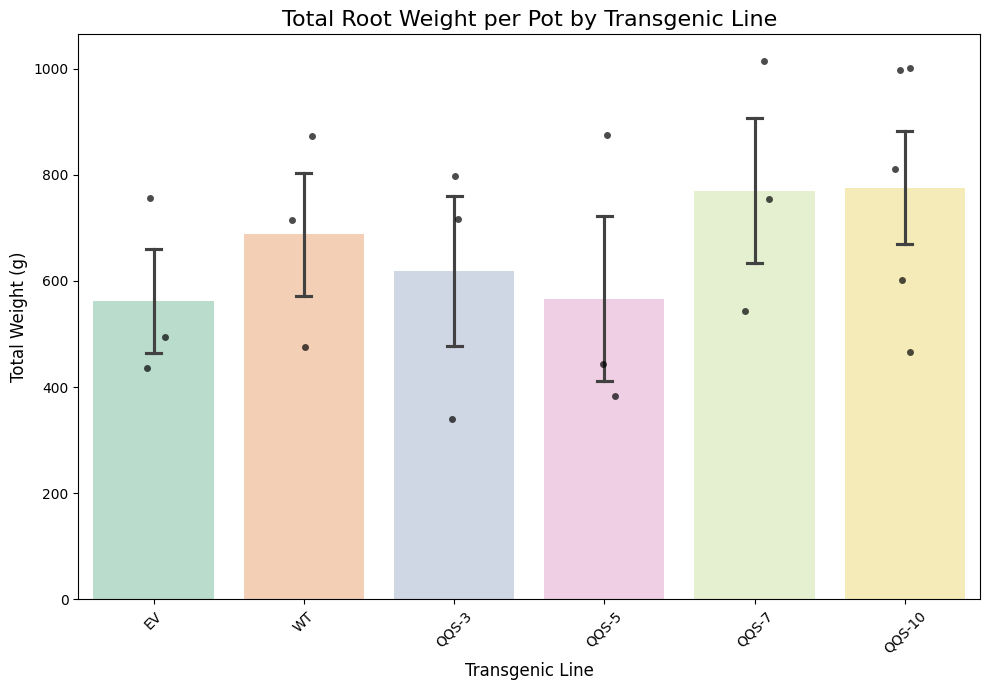

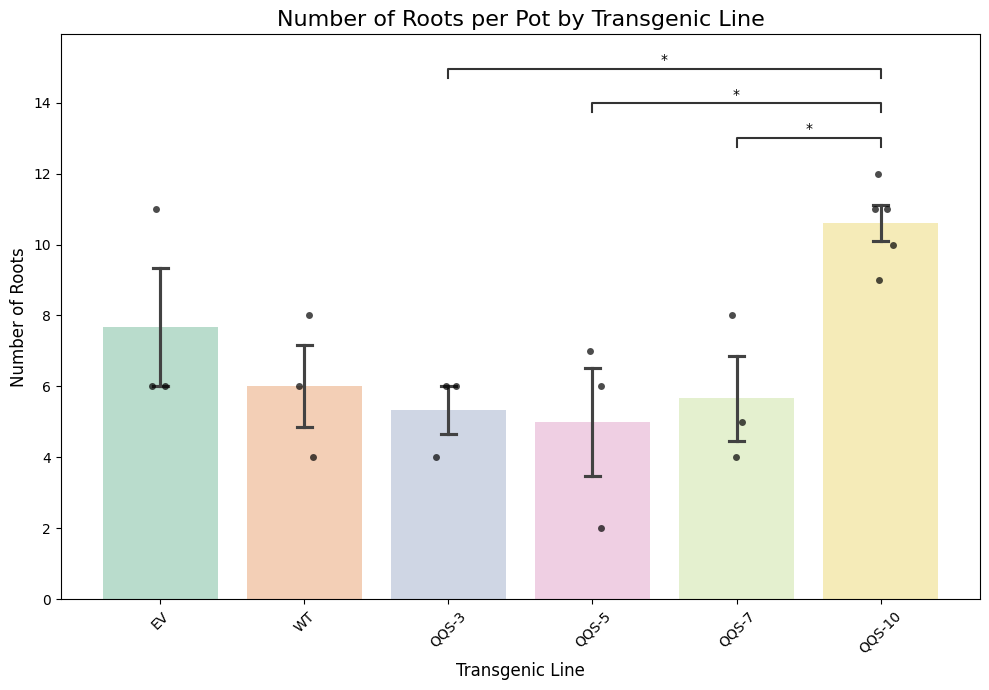

In [87]:
# Define a consistent order and color palette
palette = "Pastel2"
stripplot_color = "black"

# --- Plot 1: Total Weight Bar Plot ---
print("Generating 'total_weight_barplot.png'...")
plt.figure(figsize=(10, 7))
ax1 = sns.barplot(x='Transgenic_Line', y='Total_Weight', data=pot_df, 
                    order=plot_order, palette=palette, 
                    capsize=0.1, errorbar='se') # Use standard error

sns.stripplot(x='Transgenic_Line', y='Total_Weight', data=pot_df, 
                order=plot_order, color=stripplot_color, 
                jitter=True, alpha=0.7, ax=ax1)

ax1.set_title('Total Root Weight per Pot by Transgenic Line', fontsize=16)
ax1.set_ylabel('Total Weight (g)', fontsize=12)
ax1.set_xlabel('Transgenic Line', fontsize=12)
ax1.tick_params(axis='x', rotation=45)

# Add statistical annotations if present
if len(ttest_df_weight) > 0 and 'line1' in ttest_df_weight.columns:
    pairs = list(zip(ttest_df_weight['line1'], ttest_df_weight['line2']))
    
    if pairs:
        print(f"Adding {len(pairs)} significance annotations...")
        p_values = ttest_df_weight['p_adj'].tolist()
        
        try:
            annotator = Annotator(ax1, pairs, data=pot_df, 
                                 x='Transgenic_Line', y='Total_Weight', 
                                 order=plot_order)
            annotator.configure(text_format='star', loc='inside', verbose=False)
            annotator.set_pvalues_and_annotate(p_values)
            print("✓ Annotations added successfully")
        except Exception as e:
            print(f"✗ Could not add annotations: {e}")
else:
    print("No significant comparisons to annotate")

plt.tight_layout()
plt.savefig('total_weight_barplot.png')
print("Saved 'total_weight_barplot.png'")

# --- Plot 2: Number of Roots Bar Plot ---
print("Generating 'number_of_roots_barplot.png'...")
plt.figure(figsize=(10, 7))
ax2 = sns.barplot(x='Transgenic_Line', y='Number_of_Roots', data=pot_df, 
                    order=plot_order, palette=palette, 
                    capsize=0.1, errorbar='se') # Use standard error

sns.stripplot(x='Transgenic_Line', y='Number_of_Roots', data=pot_df, 
                order=plot_order, color=stripplot_color, 
                jitter=True, alpha=0.7, ax=ax2)

ax2.set_title('Number of Roots per Pot by Transgenic Line', fontsize=16)
ax2.set_ylabel('Number of Roots', fontsize=12)
ax2.set_xlabel('Transgenic Line', fontsize=12)
ax2.tick_params(axis='x', rotation=45)

# Add statistical annotations if present
if len(ttest_df_roots) > 0 and 'line1' in ttest_df_roots.columns:
    pairs_roots = list(zip(ttest_df_roots['line1'], ttest_df_roots['line2']))
    
    if pairs_roots:
        print(f"Adding {len(pairs_roots)} significance annotations...")
        p_values_roots = ttest_df_roots['p_adj'].tolist()
        
        try:
            annotator_roots = Annotator(ax2, pairs_roots, data=pot_df, 
                                       x='Transgenic_Line', y='Number_of_Roots', 
                                       order=plot_order)
            annotator_roots.configure(text_format='star', loc='inside', verbose=False)
            annotator_roots.set_pvalues_and_annotate(p_values_roots)
            print("✓ Annotations added successfully")
        except Exception as e:
            print(f"✗ Could not add annotations: {e}")
else:
    print("No significant comparisons to annotate")

plt.tight_layout()
plt.savefig('number_of_roots_barplot.png')
print("Saved 'number_of_roots_barplot.png'")
print("\nPlotting complete.")